# Проект: Прогнозирование температуры звезд


**Цель проекта:**
Обсерватория «Небо на ладони» поставила задачу разработать нейронную сеть для прогнозирования температуры на поверхности звезд.

___

**Описание данных:**

Колонки:

- ``Temperature (K)`` — температура на поверхности звезды в Кельвинах (целевой признак)
- ``Luminosity(L/Lo)`` — светимость звезды относительно Солнца
- ``Radius(R/Ro)`` — радиус звезды относительно радиуса Солнца
- ``Absolute magnitude(Mv)`` — физическая величина, характеризующая блеск звезды
- ``Star type`` — тип звезды:
  - 0 — Коричневый карлик
  - 1 — Красный карлик
  - 2 — Белый карлик
  - 3 — Звезды главной последовательности
  - 4 — Сверхгигант
  - 5 — Гипергигант
``Star color`` — цвет звезды.

___

**Алгоритм решения задачи:**

- Загрузка данных
- Исследовательский анализ данных.
- Анализ количественных признаков.
- Анализ категориальных признаков.
- Подготовка данных.
- Разделение на обучающую и тестовую выборки.
- Построение базовой модели.
- Анализ показатель базовой модели на основе графика и значений MRSE
- Улучшение модели путем перебора и добавления новых параметров
- Довести показатели MRSE до отметки **4500 и меньше**
- Сделать выводы

## Загрузка данных

In [1]:
!pip install scikit-learn==1.1.3
!pip install phik
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

SEED = 42 
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

In [2]:
df = pd.read_csv('/datasets/6_class.csv')
df

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red
...,...,...,...,...,...,...,...
235,235,38940,374830.000000,1356.0000,-9.93,5,Blue
236,236,30839,834042.000000,1194.0000,-10.63,5,Blue
237,237,8829,537493.000000,1423.0000,-10.73,5,White
238,238,9235,404940.000000,1112.0000,-11.23,5,White


In [3]:
def explore_df(df):
    print(f"Размеры: {df.shape[0]} строк и {df.shape[1]} столбцов")
    print()
    print("Типы данных:")
    print(df.dtypes)
    print()
    print(f"Количество дубликатов: {df.duplicated().sum()}")
    print()
    print("Пропуски:")
    print(df.isna().sum())
    print()
    print("Статистики количественных показателей:")
    display(df.describe())

explore_df(df)

Размеры: 240 строк и 7 столбцов

Типы данных:
Unnamed: 0                  int64
Temperature (K)             int64
Luminosity(L/Lo)          float64
Radius(R/Ro)              float64
Absolute magnitude(Mv)    float64
Star type                   int64
Star color                 object
dtype: object

Количество дубликатов: 0

Пропуски:
Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

Статистики количественных показателей:


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


Выводы:

- В датасете 240 строк и 7 столбцов.
- Типы данных корректные
- Пропуски и дубликаты в данных отсутствуют.
- Названия колонок содержат пробелы и специальные символы.
- Значения в столбце Luminosity(L/Lo) имеют сильный разброс
- В столбце Radius(R/Ro) также значительный разброс
- Столбец Temperature (K) варьируется от 1939 до 40000 - целевой признак, надо смотреть на графике

Следующие шаги:

- Привести названия столбцов к формату snake_case для улучшения читаемости.
- Удаление ``Unnamed: 0`` - столбец не несет смысловой нагрузки, является индексом
- Построить графики распределения количественных признаков

## Предобработка и анализ данных

In [4]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [5]:
df.rename(columns={
    'Temperature (K)': 'temperature_k',
    'Luminosity(L/Lo)': 'luminosity_lo',
    'Radius(R/Ro)': 'radius_ro',
    'Absolute magnitude(Mv)': 'absolute_magnitude_mv',
    'Star type': 'star_type',
    'Star color': 'star_color'
}, inplace=True)

print(df.columns)

Index(['temperature_k', 'luminosity_lo', 'radius_ro', 'absolute_magnitude_mv',
       'star_type', 'star_color'],
      dtype='object')


In [6]:
def plot_num(data, column):

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})
    
    #гист
    sns.histplot(data[column], bins=30, ax=axes[0], color='royalblue')
    axes[0].set_title(f'Распределение: {column}', fontsize=14)
    axes[0].set_ylabel('Частота', fontsize=12)
    axes[0].set_xlabel('')
    
    #боксплот
    sns.boxplot(data=data, x=column, ax=axes[1], color='skyblue')
    axes[1].set_title(f'Боксплот: {column}', fontsize=14)
    axes[1].set_xlabel(column, fontsize=12)
    
    plt.tight_layout()
    plt.show()

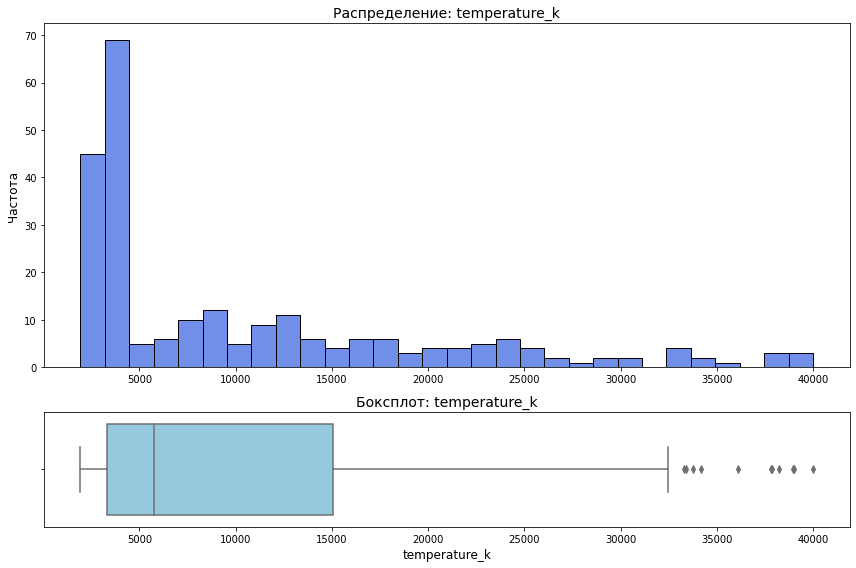

In [7]:
plot_num(df, 'temperature_k')

В целевом признаке явных аномалий не обнаружено. Есть выбросы, но они выглядят логичными для данных о звёздах и их температуре. Решили не удалять эти значения, чтобы сохранить разнообразие данных и не повредить точности прогноза модели

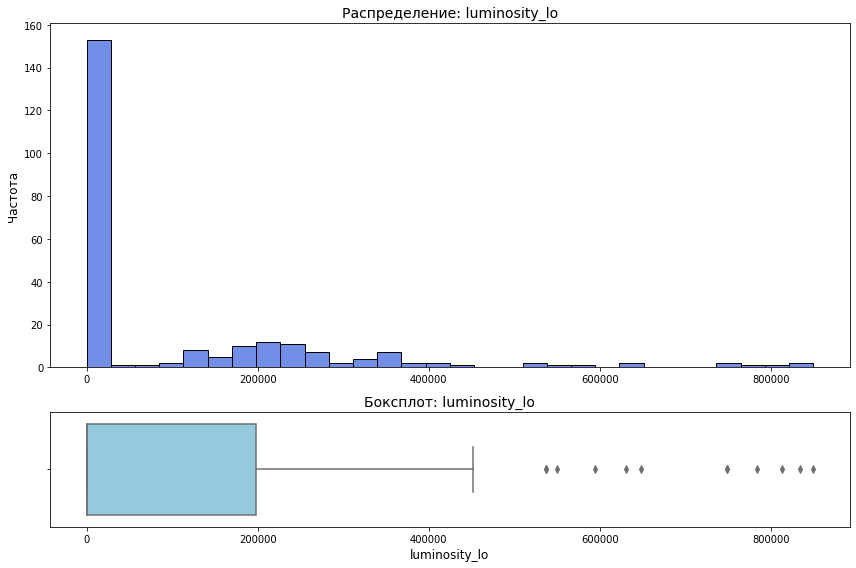

In [8]:
plot_num(df, 'luminosity_lo')

Аналогично, пока оставим выбросы в колонке с относительной светимостью звезд

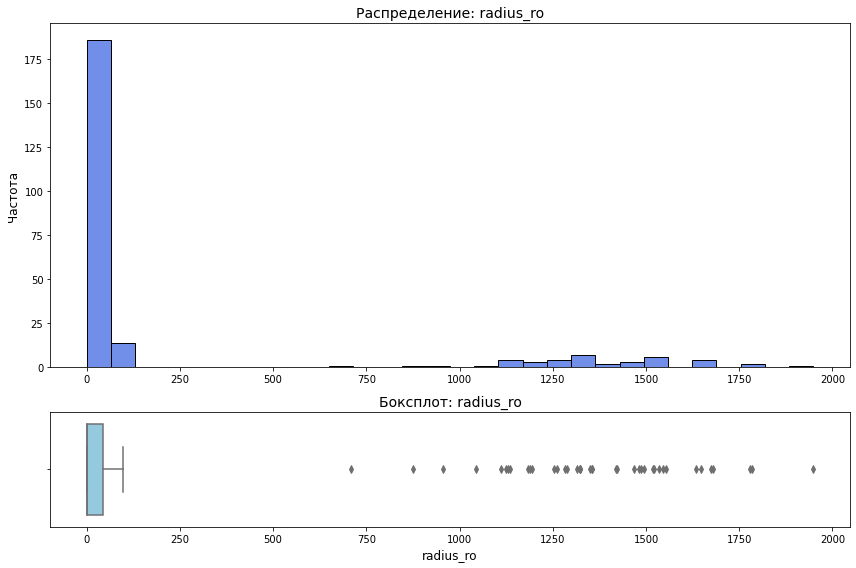

In [9]:
plot_num(df, 'radius_ro')

В ``radius_ro`` обнаружены явные аномалии, но существуют супер гиганты, решено оставить, чтобы не удалять целый класс звезд

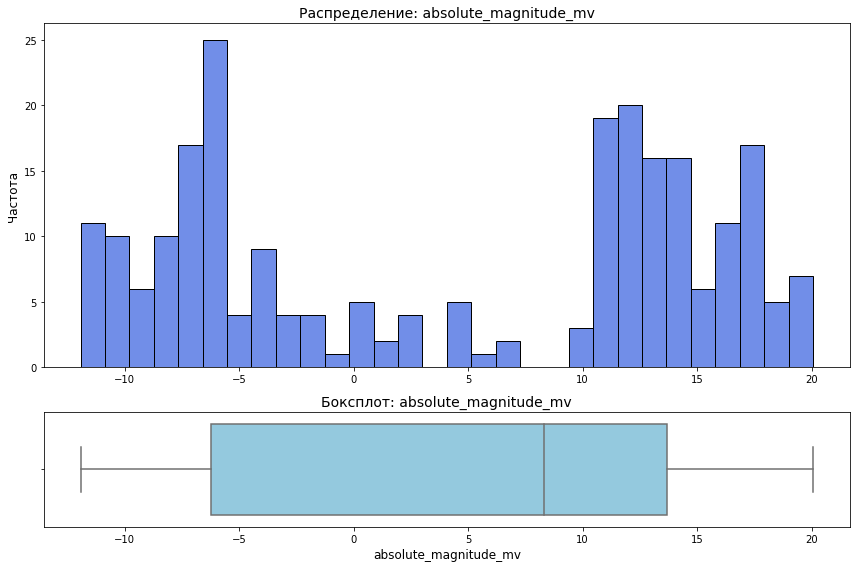

In [10]:
plot_num(df, 'absolute_magnitude_mv')

Значения в ``absolute_magnitude_mv`` выглядят естественно, выбросов или аномалий не обнаружено. Никаких изменений в данных вносить не нужно.

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

In [11]:
def plot_cat(data, column):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=column, palette='viridis', order=data[column].value_counts().index)
    plt.title(f'Распределение: {column}', fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Количество', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

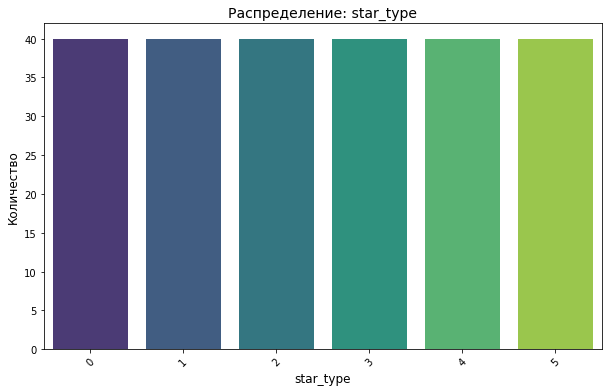

In [12]:
plot_cat(df, 'star_type')

Распределение звёзд по типам равномерное, все пять типов звёзд представлены одинаково

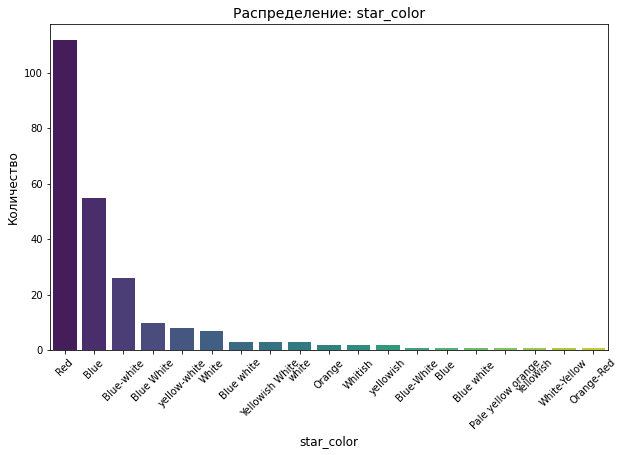

In [13]:
plot_cat(df, 'star_color')

В ``star_color`` необходимо объединить похожие по смыслу категории: blue white и blue-white, а также привели значения к единому формату

In [14]:
df.loc[:, 'star_color'] = df['star_color'].str.lower().str.strip()

df.loc[:, 'star_color'] = df['star_color'].replace({
    'blue white': 'blue-white',
    'yellowish white': 'yellow-white',
    'white-yellow': 'yellow-white',
    'whitish': 'white',
    'yellowish': 'yellow',
    'pale yellow orange': 'pale yellow-orange'
})

print(df['star_color'].value_counts())

red                   112
blue                   56
blue-white             41
white                  12
yellow-white           12
yellow                  3
orange                  2
orange-red              1
pale yellow-orange      1
Name: star_color, dtype: int64


Объединим в категорию **other** значения с единичными показателями

red             112
blue             56
blue-white       41
white            12
yellow-white     12
other             7
Name: star_color, dtype: int64


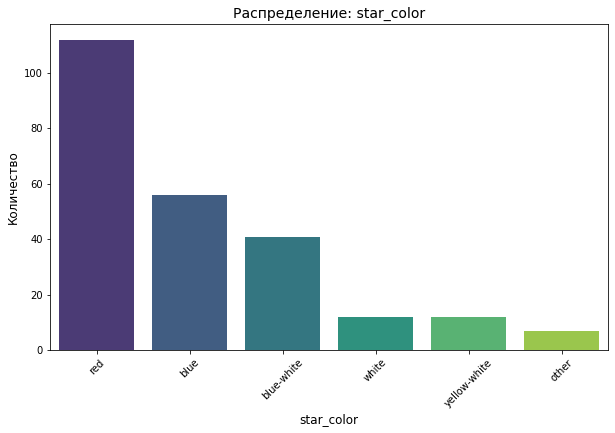

In [15]:
common_colors = ['red', 'blue', 'blue-white', 'yellow-white', 'white']
df.loc[:, 'star_color'] = df['star_color'].apply(lambda x: x if x in common_colors else 'other')

print(df['star_color'].value_counts())

plot_cat(df, 'star_color')

Построим матрицу корреляции и проверим на мультиколлинеарность

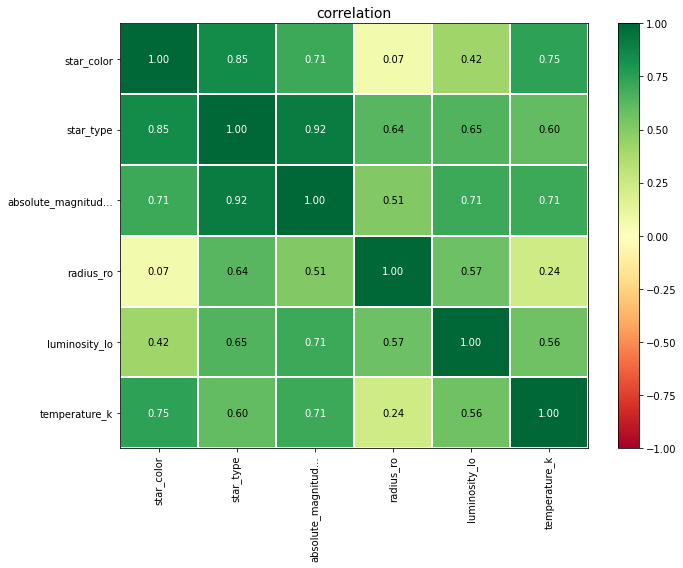

In [16]:
correlation_matrix = df.phik_matrix(interval_cols=['luminosity_lo', 'radius_ro', 'absolute_magnitude_mv', 'temperature_k'])

plot_correlation_matrix(
    correlation_matrix.values,
    x_labels=correlation_matrix.columns,
    y_labels=correlation_matrix.index,
    vmin=-1,
    vmax=1,
    figsize=(10, 8))

Мультиколлинеарности нет, можно продолжать работать без изменения признаков

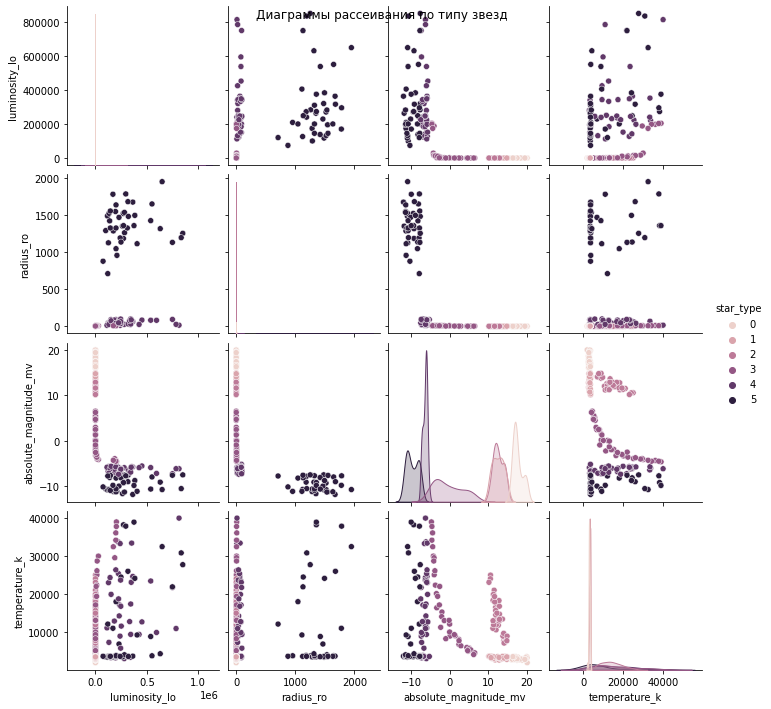

In [17]:
variables = ['luminosity_lo', 'radius_ro', 'absolute_magnitude_mv', 'temperature_k']

sns.pairplot(df, vars=variables, hue='star_type')
plt.suptitle('Диаграммы рассеивания по типу звезд')
plt.show()

Закономерности:
- Размер звезды не всегда связан с температурой. Видно, что некоторые очень большие звезды могут быть как холодными, так и горячими.
- Яркость и температура связаны. Звезды с положительной абсолютной величиной чаще имеют низкую температуру.
- Звезды разного типа образуют группы. Видно, что разные типы звезд располагаются в своих зонах.

Можно сделать выводы, что связи соответствуют реальным астрономическим законам; типы звезд играют роль в объяснении закономерностей; по графикам можно утверждать, что предсказание температуры возможно на основе этих данных

Выводы:

- ``temperature`` выбросы присутствуют, но они ожидаемы, так как температура звёзд варьируется в широком диапазоне. Решено оставить все данные
- ``radius_ro`` выявлены явные аномалии, которые составляют ~16% данных, но существуют звезды-гиганты, у нас это целый класс, не удялем
- ``absolute_magnitude_mv`` распределение асимметричное, но в рамках логики задачи ничего критичного
- Отсутствует мультиколлинеарность

Анализ категориальных признаков:

- ``star_type`` распределение равномерное между типами звёзд
- ``star_color`` Приведены названия цветов к одному формату. Выделили 5 наиболее распространенных цветов, прочите объединили в **other**

## Построение базовой нейронной сети

Для построение базовой модели необходимо выделить целевой признак и закодировать категориальные переменные, нормализовать количественные

In [18]:
X = df.drop(columns=['temperature_k'])
y = df['temperature_k']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = ['luminosity_lo', 'radius_ro', 'absolute_magnitude_mv']
categorical_features = ['star_color', 'star_type']


num_pipe = Pipeline([
    ('scaler', StandardScaler())
])


cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
])

data_preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, categorical_features)
], remainder='passthrough')

X_train_processed = data_preprocessor.fit_transform(X_train)
X_test_processed = data_preprocessor.transform(X_test)

#преобразование в формат тензоров, чтобы обучать нейросеть
X_train_tensor = torch.FloatTensor(X_train_processed)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)

X_test_tensor = torch.FloatTensor(X_test_processed)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)


In [19]:
#создадим функцию для базовой нейросети
def create_model(input_size, hidden_neurons):
    model = nn.Sequential(
        nn.Linear(input_size, hidden_neurons),  #1 скрытый слой
        nn.Tanh(),                              #активация Tanh
        nn.Linear(hidden_neurons, 32),          #2 скрытый слой
        nn.ReLU(),                              #активация ReLU
        nn.Linear(32, 1)                        #выходной слой
    )
    return model

In [20]:
#функиця для обучения модели
def train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=100, batch_size=32):
    #оптимизатор и функция потерь
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    n_samples = X_train_tensor.shape[0]

    #обучение
    model.train()
    for epoch in range(epochs):
        for i in range(0, n_samples, batch_size):
            X_batch = X_train_tensor[i:i+batch_size]
            y_batch = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()               #обнуление градиента 
            outputs = model(X_batch)            #прямой подход к обучению
            loss = criterion(outputs, y_batch)  #считаем ошибку
            loss.backward()                     #обратное распростарнение
            optimizer.step()                    #обнволение весов

    #оценка
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test_tensor).numpy()
        test_rmse = np.sqrt(mean_squared_error(y_test_tensor.numpy(), y_test_pred))
    
    return test_rmse

In [21]:
input_size = X_train_tensor.shape[1]  #вводные признаки
hidden_neurons = 64  #нейроны в скрытом слое
batch_size = 32  #размер батча
epochs = 1000  #эпохи

#модель
model = create_model(input_size=input_size, hidden_neurons=hidden_neurons)

#обучение и метрика
test_rmse = train_model(
    model=model,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test_tensor=y_test_tensor,
    epochs=epochs,
    batch_size=batch_size
)

print(f"RMSE на тестовой выборке базовой модели: {test_rmse:.2f}")

RMSE на тестовой выборке базовой модели: 5076.55


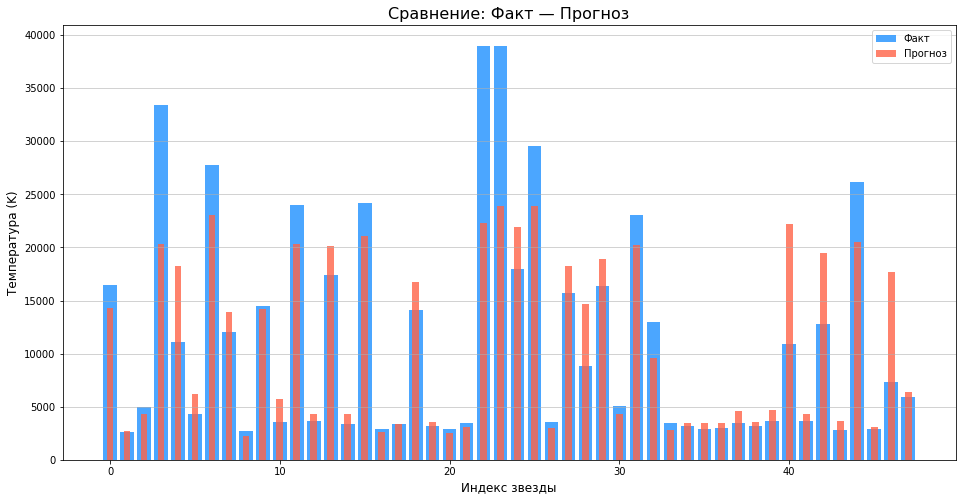

In [22]:
#предсказание на тестовой выборке
model.eval()
y_test_pred = model(X_test_tensor).detach().numpy().flatten()  #предсказание


n_samples = len(y_test)
plt.figure(figsize=(16, 8))
plt.bar(range(n_samples), y_test.values[:n_samples], label='Факт', color='dodgerblue', alpha=0.8)
plt.bar(range(n_samples), y_test_pred[:n_samples], label='Прогноз', color='tomato', alpha=0.8, width=0.4)
plt.title('Сравнение: Факт — Прогноз', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xlabel('Индекс звезды', fontsize=12)
plt.ylabel('Температура (K)', fontsize=12)
plt.legend()
plt.show()


In [23]:
for i in range(10):
    real = y_test.values[i]
    predicted = y_test_pred[i]
    print(f"Номер{i + 1}: Фактическое значение = {real:.2f}, Предсказанное значение = {predicted:.2f}")

Номер1: Фактическое значение = 16500.00, Предсказанное значение = 14264.91
Номер2: Фактическое значение = 2637.00, Предсказанное значение = 2712.94
Номер3: Фактическое значение = 4980.00, Предсказанное значение = 4335.43
Номер4: Фактическое значение = 33421.00, Предсказанное значение = 20312.63
Номер5: Фактическое значение = 11096.00, Предсказанное значение = 18271.46
Номер6: Фактическое значение = 4287.00, Предсказанное значение = 6164.59
Номер7: Фактическое значение = 27739.00, Предсказанное значение = 23082.11
Номер8: Фактическое значение = 12010.00, Предсказанное значение = 13962.59
Номер9: Фактическое значение = 2700.00, Предсказанное значение = 2219.90
Номер10: Фактическое значение = 14520.00, Предсказанное значение = 14226.11


Выводы:

- Задали базовую модель нейронной сети с двумя скрытыми слоями. Первый слой состоял из 64 нейронов с функцией активации Tanh, а второй слой — из 32 нейронов с активацией ReLU. На выходе использовался один нейрон для предсказания температуры. Для обучения модели применили оптимизатор Adam с функцией потерь MSELoss


- RMSE на тестовой выборке -  14343.16. Высокое значение ошибки, что показывает большеое расхождение между фактом и прогнозом модели
- Модель показала узкий диапазон предсказанных значений ~1200 для всех объектов, в то время как реальные значения температуры в разы больше
- Построили график и убедилисть, что моджель покам слабо улавливает зависимости

В следующем шаге мы усложним модель, чтобы она смогла лучше находить нелинейные связи:
- Увеличим число нейронов
- Добавление Dropout для предотвращения переобучения
- Изменим размера батчей и количества эпох
- Задача добиться RMSE < 4500 

## Улучшение нейронной сети

In [24]:
def create_model(input_size, hidden_neurons, dropout_rate):
    model = nn.Sequential(
        nn.Linear(input_size, hidden_neurons),  #первый скрытый слой
        nn.Tanh(),                              #первая активация
        nn.Dropout(dropout_rate),               #dropout
        nn.Linear(hidden_neurons, 32),          #второй скрытый слой
        nn.ReLU(),                              #вторая активация
        nn.Linear(32, 1)                        #выходной слой
    )
    return model

In [25]:
results = []
hidden_neurons_list = [400, 512, 600]  #диапазон найеронов
dropout_list = [0.1, 0.15]            #диапазон дропаута
batch_size_list = [16, 32]            #диапазон батчей 
epochs = 600                          #эпоха

for hidden_neurons in hidden_neurons_list:
    for dropout_rate in dropout_list:
        for batch_size in batch_size_list:
            model = create_model(X_train_tensor.shape[1], hidden_neurons, dropout_rate)
            rmse = train_model(
                model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
                batch_size=batch_size, epochs=epochs
            )
            results.append({'hidden_neurons': hidden_neurons, 'dropout': dropout_rate, 'batch_size': batch_size, 'rmse': rmse})
            print(f"Hidden Neurons: {hidden_neurons}, Dropout: {dropout_rate}, Batch Size: {batch_size}, RMSE: {rmse:.2f}")


best_result = results[0]
for result in results:
    if result['rmse'] < best_result['rmse']:
        best_result = result

print(f"Лучшие параметры: Hidden Neurons={best_result['hidden_neurons']}, "
      f"Dropout={best_result['dropout']}, Batch Size={best_result['batch_size']}, RMSE={best_result['rmse']:.2f}")

Hidden Neurons: 400, Dropout: 0.1, Batch Size: 16, RMSE: 4280.85
Hidden Neurons: 400, Dropout: 0.1, Batch Size: 32, RMSE: 4633.54
Hidden Neurons: 400, Dropout: 0.15, Batch Size: 16, RMSE: 4258.27
Hidden Neurons: 400, Dropout: 0.15, Batch Size: 32, RMSE: 4654.95
Hidden Neurons: 512, Dropout: 0.1, Batch Size: 16, RMSE: 4255.92
Hidden Neurons: 512, Dropout: 0.1, Batch Size: 32, RMSE: 4341.27
Hidden Neurons: 512, Dropout: 0.15, Batch Size: 16, RMSE: 4239.54
Hidden Neurons: 512, Dropout: 0.15, Batch Size: 32, RMSE: 4755.36
Hidden Neurons: 600, Dropout: 0.1, Batch Size: 16, RMSE: 4217.26
Hidden Neurons: 600, Dropout: 0.1, Batch Size: 32, RMSE: 4333.80
Hidden Neurons: 600, Dropout: 0.15, Batch Size: 16, RMSE: 4264.09
Hidden Neurons: 600, Dropout: 0.15, Batch Size: 32, RMSE: 4581.23
Лучшие параметры: Hidden Neurons=600, Dropout=0.1, Batch Size=16, RMSE=4217.26


In [26]:
#лучшите параметры
best_hidden_neurons = 600
best_dropout = 0.1
best_batch_size = 16
best_epochs = 600

#итоговая модель
final_model = create_model(
    input_size=X_train_tensor.shape[1], 
    hidden_neurons=best_hidden_neurons, 
    dropout_rate=best_dropout
)

#обучение
final_rmse = train_model(
    model=final_model,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_test_tensor=X_test_tensor,
    y_test_tensor=y_test_tensor,
    batch_size=best_batch_size,
    epochs=best_epochs
)

print(f"Финальный RMSE на тестовой выборке: {final_rmse:.2f}")

Финальный RMSE на тестовой выборке: 4235.04


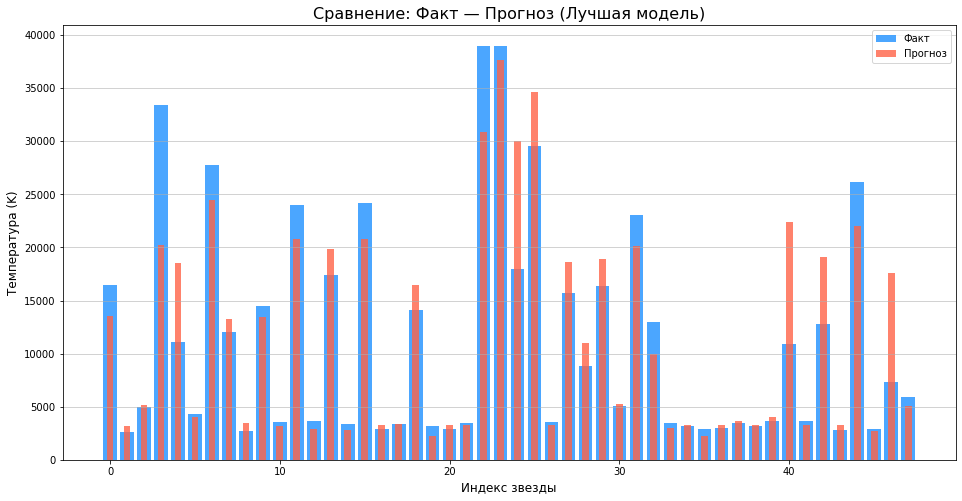

In [27]:
final_model.eval()
y_test_pred = final_model(X_test_tensor).detach().numpy().flatten()

n_samples = len(y_test_pred)
plt.figure(figsize=(16, 8))
plt.bar(range(n_samples), y_test.values[:n_samples], label='Факт', color='dodgerblue', alpha=0.8)
plt.bar(range(n_samples), y_test_pred[:n_samples], label='Прогноз', color='tomato', alpha=0.8, width=0.4)
plt.title('Сравнение: Факт — Прогноз (Лучшая модель)', fontsize=16)
plt.grid(axis='y', alpha=0.7)
plt.xlabel('Индекс звезды', fontsize=12)
plt.ylabel('Температура (K)', fontsize=12)
plt.legend()
plt.show()

Выводы:

- Подобрали лучшие гиперпараметры для модели путем перебора:
 - Количество нейронов: 600
 - Dropout: 0.1
 - Размер батча: 16
 - Количество эпох: 600
- Построили модель с обновленной архитектурой, добавив **слой Dropout**
- После финального обучения модели получили RMSE = 4235.04, что значительно **меньше порога задачи в 4500**
- Построили график «Факт — Прогноз» и увидели, что модель стала существенно точнее в предсказаниях

## Выводы

Целью проекта являлось разработать модель на основе нейросети, которая способна точно предсказывать температуру на поверхности звезд

Выполненые шаги:
- Мы начали с анализа данных, состоящих из 240 объектов с характеристиками звезд. Целевой переменной была температура звезды в Кельвинах


- Провели исследование количественных и категориальных данных
  - Были выявлены выбросы в признаке ``radius_ro``, которые составляли около 16% от выборки, решили не удалять, так как это привело бы к удалению целого класса звезд сверхгигантов
  - Для категориального признака ``star_color`` обнаружили значения с похожими названиями. Мы объединили схожие категории и выделили пять основных цветов, оставив прочие в категории **other**


- Разделили данные на обучающую и тестовую выборки
- Применили стандартизацию и кодирование
- Преобразовали данные в формат тензоров для обучения модели.


- Создали базовую архитектуру нейросети, состоящую из двух скрытых слоев с активациями **Tanh** и **ReLU**
  - Базовая модель обучалась без использования Dropout. Параметры:
   - Количество нейронов: 64
   - Эпохи: 100
   - Размер батча: 32
- После обучения базовая модель показала RMSE = 14343.16. График «Факт — Прогноз» подтвердил, что модель показывает высокую ошибку и плохо обучилась, не смогла найти связи


- Улучшили архитектуру, добавив **Dropout**
- Использовали перебор гиперпараметров:
  - Количество нейронов: 400, 512, 600
  - Dropout: 0.1, 0.15
  - Размер батча: 16, 32
  - Эпохи: 600
- После перебора гиперпараметров взяли лучшие параметры:
 - Количество нейронов: 600
 - Dropout: 0.1
 - Размер батча: 16
 - Эпохи: 600
 

- Обучили улучшенную модель с использованием лучших параметров, RMSE = 4235.04. График показал, что модель стала точнее, и предсказания приближаются к реальным значениям.

___

Все этапы проекта были выполнены, начиная с анализа данных и их предобработки до построения и улучшения модели.
Базовая модель показала недостаточно хорошие результаты, что показало необхзодимость улучшения модели
Итоговая модель полностью отвечает задаче и может быть использована для прогнозирования температуры с относительно высокой точностью